#  Introduction and Summary
This notebook uses a variety of Machine Learning models on data about shared micromobility services in Austin, Texas. In this case, micromobility refers to both scooters and bicycles which can be rented and dropped off at dockless locations. The data can be found <a href="https://data.austintexas.gov/Transportation-and-Mobility/Shared-Micromobility-Vehicle-Trips/7d8e-dm7r">here</a>.

Initial analysis of the data shows:
1. Usage can vary regardless of time, but tends to be highest in the afternoons, such as between 3pm - 5pm. 
2. Usage continues to vary regardless of month, but tends to be highest in March and August. This can be tied to SXSW in March and the beginning of the school year for UT Austin in August. 
3. Weather does not seem to impact usage of micromobility services. 
4. There's not a strong relationship between Trip Duration and Trip Distance. 
5. Typical linear regression models don't work well with this data, but a Decision Tree Classifier may be the best fit. 

# Load Libraries and Data 
We'll import other libraries as we use them throughout the notebook.

In [1]:
# Import Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import statsmodels.api as sm
import seaborn as sns

In [2]:
# Import data, drop unnecessary columns, and update data types
all_vehicles = pd.read_csv("data/all_summary.csv")
all_vehicles = all_vehicles.drop('Unnamed: 0', axis=1)

In [3]:
alltrips = pd.read_csv("data/alltrips_cleaned.csv")
alltrips = alltrips.drop('Unnamed: 0',axis=1)

In [4]:
all_vehicles.head()

,Month,Hour,Year,Day,Count,date,maxtemp,atemp,mintemp,maxhum,ahum,minhum,maxwind,awind,minwind,prec,Day of week,Vehicle Type,Vehicle Encoded
0,1,0,2019,1,342,2019-01-01,46.0,41.5,36.0,97.0,83.5,76.0,21.0,11.2,0.0,0.0,1.0,scooter,0
1,1,0,2019,2,79,2019-01-02,41.0,38.3,37.0,97.0,92.2,79.0,15.0,10.8,8.0,1.0,2.0,scooter,0
2,1,0,2019,3,16,2019-01-03,52.0,40.5,31.0,97.0,85.4,53.0,13.0,7.5,0.0,1.0,3.0,scooter,0
3,1,0,2019,4,82,2019-01-04,67.0,46.0,30.0,96.0,66.7,31.0,10.0,3.8,0.0,1.0,4.0,scooter,0
4,1,0,2019,5,188,2019-01-05,73.0,49.1,32.0,93.0,66.4,24.0,13.0,4.3,0.0,0.0,5.0,scooter,0


In [5]:
alltrips.head()

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Month,Hour,Day of Week,Year
0,1d4f5d89-c044-46cb-8674-80d37fa0371f,caa0325c-7c0b-4909-a573-d83126ecc953,scooter,570,826,04/29/2019 05:15:00 PM,04/29/2019 05:15:00 PM,4,17,1,2019
1,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438,1815,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,2019
2,e1ac0e42-ab2d-4eac-b019-f085169c1d38,1d89f9e2-d01a-4736-b7d8-258cb9a2108c,scooter,391,1519,04/29/2019 05:30:00 PM,04/29/2019 05:30:00 PM,4,17,1,2019
3,1c8b3eab-6aed-4b69-8eca-6b5e0b70a45f,ab262134-2421-49b7-a97f-fadde23e71db,scooter,570,1843,04/29/2019 05:30:00 PM,04/29/2019 05:45:00 PM,4,17,1,2019
4,f9174176-9d16-431d-af21-ebcab226da31,73e8b0bf-3aae-4f80-8683-c5d7c3b3989a,scooter,668,2829,04/29/2019 05:15:00 PM,04/29/2019 05:30:00 PM,4,17,1,2019


# Exploratory Data Analysis

<b>Analysis</b>
1. Demand can be higher or lower regardless of hour. For example, hour 15 has points at both ~3000 and 0. Therefore, we should expect demand by hour to be highly variable. 
2. Usage can be highest in the months of March and August. This ties to SXSW and the beginning of the school year for UT Austin, where many bikes and scooters are located. 
3. Usage doesn't seem to be impacted by average temperate, humidity, wind, or precipitation.
4. Trip distance and duration don't seem to have a meaningful relationship. Distance and duration can vary. 

In [6]:
# Make sure data is cleaned up before plotting
all_vehicles = all_vehicles.dropna()

In [7]:
alltrips['Trip Duration'] = alltrips['Trip Duration'].astype('int')

In [8]:
alltrips = alltrips[alltrips['Trip Duration'] > 0]

In [9]:
all_vehicles['maxtemp'] = all_vehicles['maxtemp'].astype('int')
all_vehicles['atempt'] = all_vehicles['atemp'].astype('int')
all_vehicles['mintemp'] = all_vehicles['mintemp'].astype('int')
all_vehicles['maxhum'] = all_vehicles['maxhum'].astype('int')
all_vehicles['ahum'] = all_vehicles['ahum'].astype('int')
all_vehicles['minhum'] = all_vehicles['minhum'].astype('int')
all_vehicles['maxwind'] = all_vehicles['maxwind'].astype('int')
all_vehicles['awind'] = all_vehicles['awind'].astype('int')
all_vehicles['minwind'] = all_vehicles['minwind'].astype('int')
all_vehicles['prec'] = all_vehicles['prec'].astype('int')
all_vehicles['Day of week'] = all_vehicles['Day of week'].astype('int')

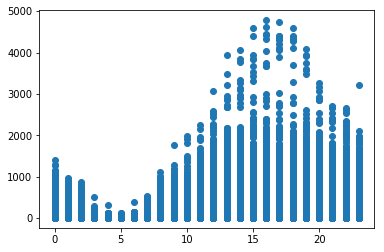

In [10]:
# Plot count against hours, months, and select weather variables
plt.scatter(all_vehicles['Hour'], all_vehicles['Count'])

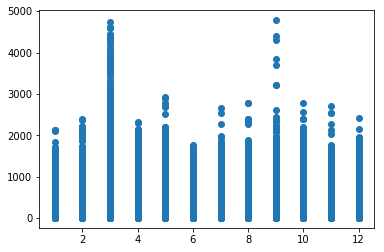

In [11]:
plt.scatter(all_vehicles['Month'], all_vehicles['Count'])

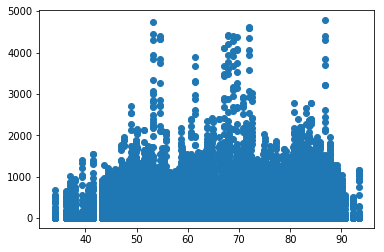

In [12]:
plt.scatter(all_vehicles['atemp'], all_vehicles['Count'])

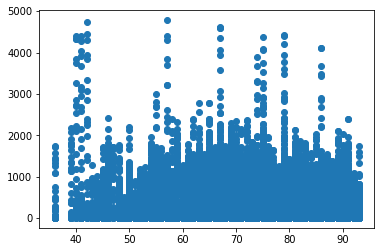

In [13]:
plt.scatter(all_vehicles['ahum'], all_vehicles['Count'])

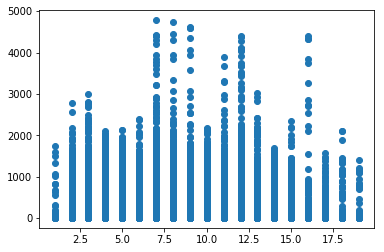

In [14]:
plt.scatter(all_vehicles['awind'], all_vehicles['Count'])

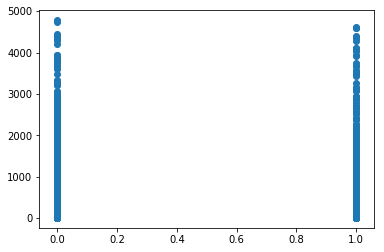

In [15]:
plt.scatter(all_vehicles['prec'], all_vehicles['Count'])

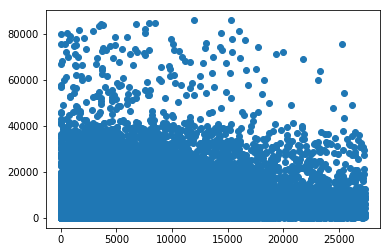

In [16]:
# Plot distance versus duration 
plt.scatter(alltrips['Trip Distance'], alltrips['Trip Duration'])

# Linear Regressions
Now that the data is cleaned, we can try our first linear regression against the data to see which variables best predict the number of devices rented. 

Upon initial evaluation, the following variables seem to have a relationship with demand:
 * hour
 * average temperature 
 * day of week
 * vehicle type (scooter vs bike)
 * month
 * average humidity 
 
However, the initial model doesn't work very well, with an adjusted R-squared of 0.549 and a testing score of 0.39. The plot also seems to indicate that there may not be a linear relationship at play with this data. 

In [17]:
# Use statsmodels to review regression results
Y = all_vehicles['Count']
X = all_vehicles[['Hour', 'atemp', 'Day of week','Vehicle Encoded','Month','ahum']]

In [18]:
model = sm.OLS(Y,X)
results = model.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     4685.
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        20:55:52   Log-Likelihood:            -1.7003e+05
No. Observations:               23128   AIC:                         3.401e+05
Df Residuals:                   23122   BIC:                         3.401e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Hour               21.0684      0.354     59.479      0.000      20.374      21.763
atemp               1.7262      0.148     11.669      0.000       1.436       2.016
Day of week        25.9898      1.218     21.339      0.000      23.603      28.377
Vehicle Encoded  -490.4116      4.958    -98.904      0.000    -500.130    -480.693
Month              -3.8445      0.820     -4.691      0.000      -5.451      -2.238
ahum                1.4351      0.148      9.683      0.000       1.145       1.726
==============================================================================
Omnibus:                    14416.931   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           325452.080
Skew:                           2.610   Prob(JB):                         0.00
Kurtosis:                      20.620   Cond. No.                         204.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Assign the data to X and y
X = all_vehicles[['Hour', 'atemp', 'Day of week','Vehicle Encoded','Month','ahum']]
y = all_vehicles['Count'].values.reshape(-1,1)
print(X.shape, y.shape)

(23128, 6) (23128, 1)


In [21]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# Create the model using LinearRegression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [23]:
# Fit the model to the training data and calculate the scores
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.36208403180290605
Testing Score: 0.38539016530904957


Text(0.5, 1.0, 'Residual Plot')

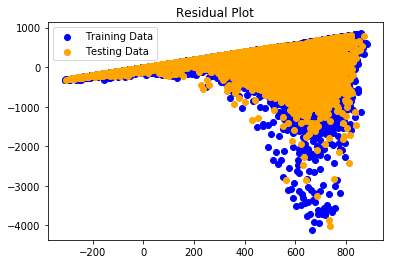

In [24]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test , c="orange", label="Testing Data")
plt.legend()
plt.title("Residual Plot")

# Feature Engineering 
To improve our linear regression model, I have binned the hours and months. The hours are binned at ~4 hour intervals and the months are binned at 3 month intervals. 

With these grouped variables, we see that the other variables still have an impact, with the inclusion of min temperature. 

However, the model actually got worse. The adjusted r-squared value is 0.554 (versus 0.559) and the testing score is still 0.39. The residual plot continues to indicate that this relationship may not be linear. 

In [25]:
all_vehicles.head()

,Month,Hour,Year,Day,Count,date,maxtemp,atemp,mintemp,maxhum,ahum,minhum,maxwind,awind,minwind,prec,Day of week,Vehicle Type,Vehicle Encoded,atempt
0,1,0,2019,1,342,2019-01-01,46,41.5,36,97,83,76,21,11,0,0,1,scooter,0,41
1,1,0,2019,2,79,2019-01-02,41,38.3,37,97,92,79,15,10,8,1,2,scooter,0,38
2,1,0,2019,3,16,2019-01-03,52,40.5,31,97,85,53,13,7,0,1,3,scooter,0,40
3,1,0,2019,4,82,2019-01-04,67,46.0,30,96,66,31,10,3,0,1,4,scooter,0,46
4,1,0,2019,5,188,2019-01-05,73,49.1,32,93,66,24,13,4,0,0,5,scooter,0,49


In [54]:
# Segment Hour and Month data
all_vehicles['Hour Encoded'] = pd.cut(all_vehicles['Hour'], bins=6, labels=[0,1,2,3,4,5])
all_vehicles['Month Encoded'] = pd.cut(all_vehicles['Month'],bins=4, labels=[0,1,2,3])
all_vehicles['Hour Encoded'] = all_vehicles['Hour Encoded'].astype('int')
all_vehicles['Month Encoded'] = all_vehicles['Month Encoded'].astype('int')

In [55]:
#reevaluate using statsmodels
Y = all_vehicles['Count']

In [56]:
X = all_vehicles[['Hour Encoded', 'Month Encoded','atemp','Vehicle Encoded','Day of week','awind','ahum','mintemp']]

In [57]:
model = sm.OLS(Y,X)

In [58]:
results = model.fit()

In [59]:
# adjusted r-squared slightlight improved
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     3589.
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        21:00:49   Log-Likelihood:            -1.6989e+05
No. Observations:               23128   AIC:                         3.398e+05
Df Residuals:                   23120   BIC:                         3.399e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Hour Encoded       84.9306      1.443     58.839      0.000      82.101      87.760
Month Encoded     -19.1523      2.498     -7.668      0.000     -24.048     -14.257
atemp               5.3901      0.410     13.150      0.000       4.587       6.193
Vehicle Encoded  -492.3025      4.937    -99.718      0.000    -501.979    -482.626
Day of week        24.6246      1.219     20.195      0.000      22.235      27.015
awind               4.5087      0.672      6.708      0.000       3.191       5.826
ahum                1.4223      0.151      9.432      0.000       1.127       1.718
mintemp            -4.1343      0.441     -9.370      0.000      -4.999      -3.269
==============================================================================
Omnibus:                    14248.872   Durbin-Watson:                   0.391
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           311940.376
Skew:                           2.577   Prob(JB):                         0.00
Kurtosis:                      20.237   Cond. No.                         239.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# evaluate the linear regression
X = all_vehicles[['Hour Encoded', 'Month Encoded','atemp','Vehicle Encoded','Day of week','awind','ahum','mintemp']]
y = all_vehicles['Count'].values.reshape(-1,1)
print(X.shape, y.shape)

(23128, 8) (23128, 1)


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [62]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [63]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.3672331545731249
Testing Score: 0.3888809944424513


Text(0.5, 1.0, 'Residual Plot')

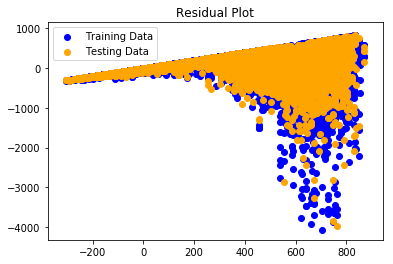

In [64]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
# plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

# Other Linear Models 
Perhaps the LinearRegression model is not the best fit for this data, but other linear models could work better. 

I tested:
* Scaled Linear Regression
* LASSO model
* Ridge model
* ElasticNet model

Out of these, the scaled linear regression and Ridge model had the lowest R2 (~0.38).

In [261]:
# Test 1: Scaled Linear Regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [262]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Ashley\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ashley\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [263]:
# Transform the training and testing data using the X_scaler and 
# y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Ashley\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\Ashley\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\Ashley\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ashley\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [264]:
# Create a LinearRegression model and fit it to the scaled training data

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

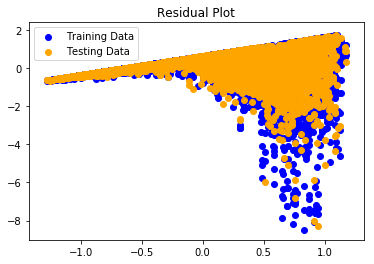

In [265]:
# Make predictions using the X_test_scaled data
# Plot y_test_scaled vs y_test_scaled
# Scatter plot y_test_scaled vs predictions

predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
# plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()

In [266]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled)
# to calculate MSE and R2

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5206350974595301, R2: 0.3888809944424513


In [267]:
# LASSO model
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.519908317512917, R2: 0.38973408529322295


In [268]:
# Ridge model
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.5206350777450751, R2: 0.38888101758318494


In [269]:
# ElasticNet model
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.520046557903069, R2: 0.38957181937959207


# Decision Tree Classifier Test 
Decision tree builds classification or regression models.

I tried both models, and it seems that classification is the best option for this data, with a score of .94.

In [270]:
from sklearn import tree
target = all_vehicles['Count']
data = all_vehicles.drop(['date','Vehicle Type'],axis=1)
feature_names = data.columns

In [271]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [272]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9368730543064684

In [80]:
X = all_vehicles[['Hour Encoded', 'Month Encoded','atemp','Vehicle Encoded','Day of week','awind','ahum','mintemp']]
y = all_vehicles['Count'].values.reshape(-1,1)

In [95]:
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=5)
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X,y)
regr_2.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [96]:
print(regr_1.score(X_test,y_test))
print(regr_2.score(X_test,y_test))

0.5879698056612646
0.756454508003736
